### Figures of spatial variation in continental vs. glacial river contributions 

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import datetime as dt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# from matplotlib import cm
from math import sin, cos, sqrt, atan2, radians
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Parameters:

In [4]:
# Domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder = '/data/brogalla/run_storage/ave-tracer-fields/'

# Boundary coordinates:
l1i = 2013-imin;                      l1j = np.arange(300-jmin,392-jmin)
l2i = 1935-imin;                      l2j = np.arange(450-jmin,530-jmin)
l3i = np.arange(1850-imin,1885-imin); l3j = 555-jmin
l4i = np.arange(1753-imin,1837-imin); l4j = 568-jmin
l5i = np.arange(1720-imin,1790-imin); l5j = 605-jmin
l6i = 1730-imin;                      l6j = np.arange(660-jmin,690-jmin)
t1i = np.arange(1635-imin,1653-imin); t1j = 760-jmin
r1i = 1520-imin;                      r1j = np.arange(505-jmin,673-jmin)
r2i = 1520-imin;                      r2j = np.arange(385-jmin,405-jmin)
N1i = np.arange(1570-imin,1630-imin); N1j = 635-jmin #Nares
P1i = 1585-imin;                      P1j = np.arange(485-jmin,538-jmin)  #Parry channel
P1j = P1j[10:-5]; N1i = N1i[11:-8]

land_color = '#a9a7a2'

# Color map:
N = 256
# #d67434 #ab5c29
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(171/N, 1, N)
vals_cont[:, 1] = np.linspace(92/N, 1, N)
vals_cont[:, 2] = np.linspace(41/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

# #32ab90 #0873b4
vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(8/N, 1, N)
vals_glac[:, 1] = np.linspace(115/N, 1, N)
vals_glac[:, 2] = np.linspace(180/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

vals_both = np.ones((N, 4))
vals_both[:, 0] = np.linspace(89/N, 1, N); 
vals_both[:, 1] = np.linspace(89/N, 1, N)
vals_both[:, 2] = np.linspace(89/N, 1, N)
both_cmap = ListedColormap(vals_both).reversed()

# # Color map:
# N = 256
# vals_cont = np.ones((N, 4))
# vals_cont[:, 0] = np.linspace(164/N, 1, N)
# vals_cont[:, 1] = np.linspace(116/N, 1, N)
# vals_cont[:, 2] = np.linspace(84/N, 1, N)
# cont_cmap = ListedColormap(vals_cont).reversed()

# vals_glac = np.ones((N, 4))
# vals_glac[:, 0] = np.linspace(113/N, 1, N)
# vals_glac[:, 1] = np.linspace(169/N, 1, N)
# vals_glac[:, 2] = np.linspace(144/N, 1, N)
# glac_cmap = ListedColormap(vals_glac).reversed()

# vals_both = np.ones((N, 4))
# vals_both[:, 0] = np.linspace(89/N, 1, N); 
# vals_both[:, 1] = np.linspace(89/N, 1, N)
# vals_both[:, 2] = np.linspace(89/N, 1, N)
# both_cmap = ListedColormap(vals_both).reversed()

##### Load files:

In [5]:
# Meshmasks
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]

mesh  = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
lon   = np.array(mesh.variables['nav_lon'])
lat   = np.array(mesh.variables['nav_lat'])

In [6]:
ref   = nc.Dataset('/data/brogalla/run_storage/Mn-set4-202004/ref-2002/ANHA12_EXH006_2002_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [7]:
# Load Mn results
file_ref   = 'ANHA12_EXH006_ref_seasonal_field.nc'
file_glac  = 'ANHA12_EXH006_riv-2a_seasonal_field.nc'
file_cont  = 'ANHA12_EXH006_riv-2b_seasonal_field.nc'

base_monthly = nc.Dataset(folder+file_ref); 
glac_monthly = nc.Dataset(folder+file_glac); 
cont_monthly = nc.Dataset(folder+file_cont);

dmn_base = np.array(base_monthly.variables['dissolmn'])[0,:,0,:,:]
dmn_glac = np.array(glac_monthly.variables['dissolmn'])[0,:,0,:,:]
dmn_cont = np.array(cont_monthly.variables['dissolmn'])[0,:,0,:,:]

##### Functions:

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base}} = \frac{Mn_{glacier}}{Mn_{base}} - 1 $$

In [8]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    diff_rivers = dmn_riv_on - dmn_riv_off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(diff_rivers, dmn_riv_off)
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

##### Calculations:

In [9]:
glacier_prop = calculate_prop(dmn_base, dmn_glac)
cont_prop    = calculate_prop(dmn_base, dmn_cont)

##### Figures

In [10]:
# Average over the top meters
glac_prop = np.nanmean(glacier_prop[:,0:10,:,:], axis=1)
cont_prop = np.nanmean(cont_prop[:,0:10,:,:], axis=1)

# Mask small values:
ma_glac = np.ma.masked_where((glac_prop < 0.008), glac_prop)
ma_cont = np.ma.masked_where((cont_prop < 0.008), cont_prop)
ma_both = ma_cont + ma_glac

In [11]:
reference_month = 0
# refc = np.nanmean(cont_prop[reference_month,:,:], axis=0)
# refg = np.nanmean(glac_prop[reference_month,:,:], axis=0)
refc = np.nanmean(cont_prop[:,:,:], axis=0)
refg = np.nanmean(glac_prop[:,:,:], axis=0)

diff_glac    = np.array([(glac_prop[month,:,:]-refg)*100 for month in range(0,12)])
diff_glacier = np.ma.masked_where((diff_glac < 0.3) & (diff_glac > -0.3), diff_glac)

diff_cont        = np.array([(cont_prop[month,:,:]-refc)*100 for month in range(0,12)])
diff_continental = np.ma.masked_where((diff_cont < 0.3) & (diff_cont > -0.3), diff_cont)

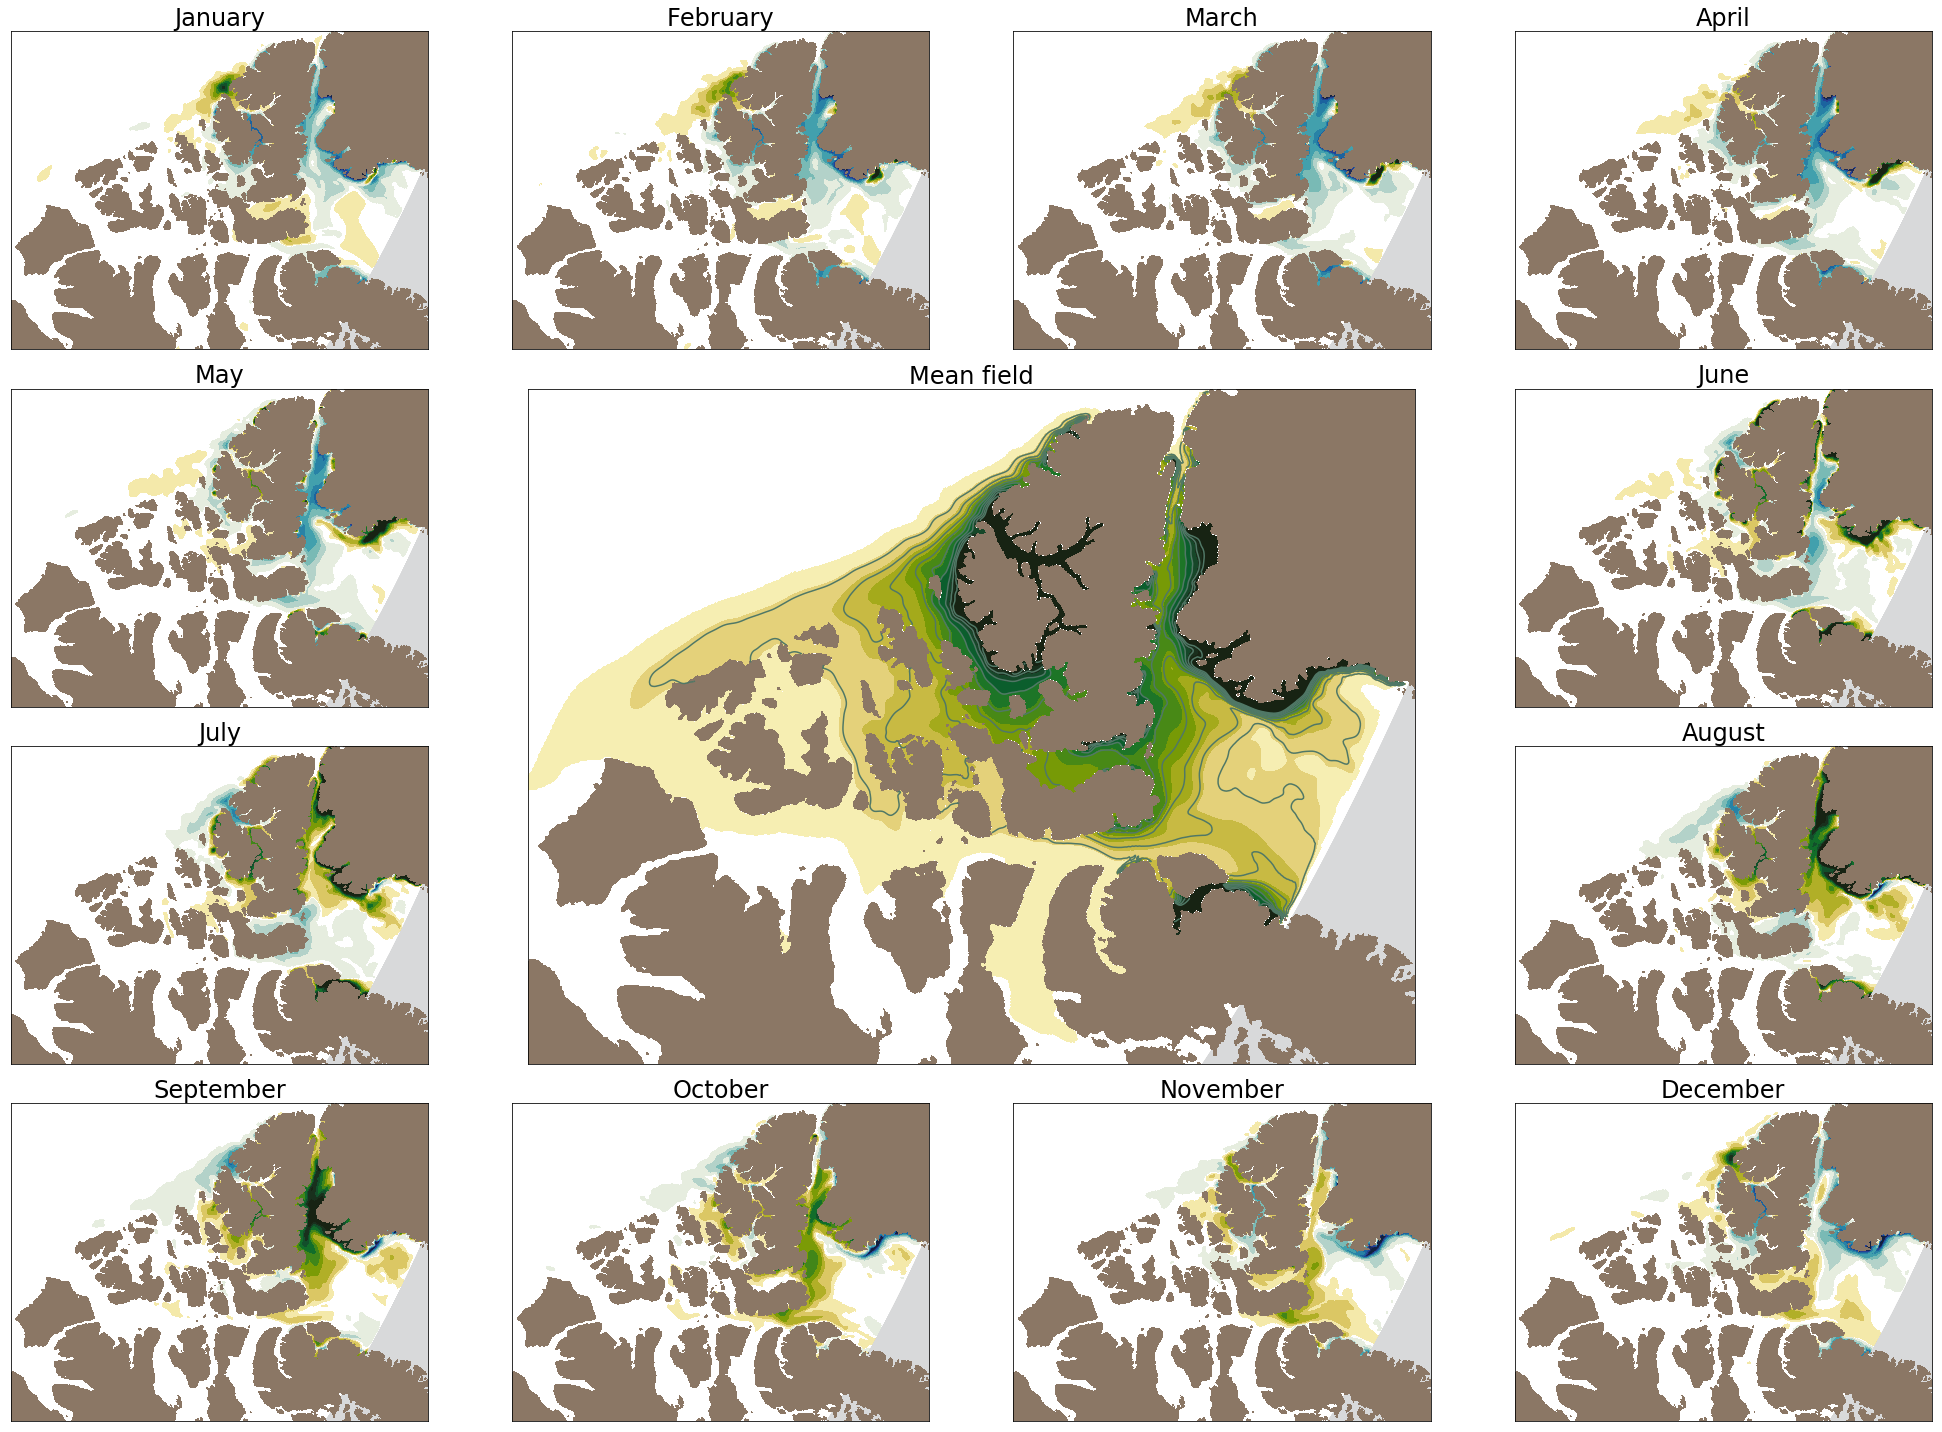

In [19]:
fig, ax = plt.subplots(4,4, figsize=(28,20))

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', \
         'August', 'September', 'October', 'November', 'December']

for month in range(0,12):
    if month < 4:
        ax1 = ax[0,month]
    elif (month == 4):
        ax1 = ax[1,0]
    elif (month == 5):
        ax1 = ax[1,3]
    elif (month == 6):
        ax1 = ax[2,0]
    elif (month == 7):
        ax1 = ax[2,3]
    else:
        ax1 = ax[3,month-8]
    
    proj2 = Basemap(projection='stere',lat_0 = 77, lon_0 = -95, resolution='l', width=2.1e6, height=1.6e6, ax=ax1)

    x_land, y_land = proj2(lon, lat)
    proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
                   cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

    #---------------------
    x_model, y_model = proj2(lons, lats)

    
    if month==13:#reference_month:
        # Coloured glacours:
        vmin_glac = -8; vmax_glac = 8; step_glac = 1;
        CS1 = proj2.contourf(x_model, y_model, ma_glac[month,:,:]*100, \
                             levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                             vmin=vmin_glac, vmax=vmax_glac, cmap=cmocean.cm.delta, extend='both')
    else:
        vmin_glac = -8; vmax_glac = 8; step_glac = 1;
        CS1 = proj2.contourf(x_model, y_model, diff_glacier[month], \
                             levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                             vmin=vmin_glac, vmax=vmax_glac, cmap=cmocean.cm.delta, extend='both')
        
    # Draw domain boundaries:
    proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#d8d9da', linewidth=10, zorder=1)
    
    ax1.set_title(months[month], fontsize=24)

ax2 = plt.subplot2grid((4, 4), (1, 1), colspan=2, rowspan=2)
proj2 = Basemap(projection='stere',lat_0 = 77, lon_0 = -95, resolution='l', width=2.1e6, height=1.6e6, ax=ax2)
x_land, y_land = proj2(lon, lat)
proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
               cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

x_model, y_model = proj2(lons, lats)

vmin_glac = -10; vmax_glac = 10; step_glac = 1;
refg_masked = np.ma.masked_where((refg*100 < 0.25), refg*100)

CS1 = proj2.contourf(x_model, y_model, refg_masked, \
                     levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                     vmin=vmin_glac, vmax=vmax_glac, cmap=cmocean.cm.delta, extend='both')


vmin_cglac = 0; contour_glac = 1.15; cvmax_glac = 10;
glac = proj2.contour(x_model, y_model, refg_masked, \
                     levels=np.arange(vmin_cglac, cvmax_glac+contour_glac, contour_glac), \
                     vmin=vmin_cglac, vmax=vmax_glac, colors='#507866')

proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#d8d9da', linewidth=10, zorder=1)
proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#d8d9da', linewidth=10, zorder=1)
proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#d8d9da', linewidth=10, zorder=1)
proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#d8d9da', linewidth=10, zorder=1)

ax2.set_title('Mean field', fontsize=24)
    
    
# ax2.text(0.0, 'Mean field', fontsize=24)
plt.tight_layout() # pad=0.4, w_pad=0.5, h_pad=0.1

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R7-monthly-CAA.png', bbox_inches='tight', dpi=300)

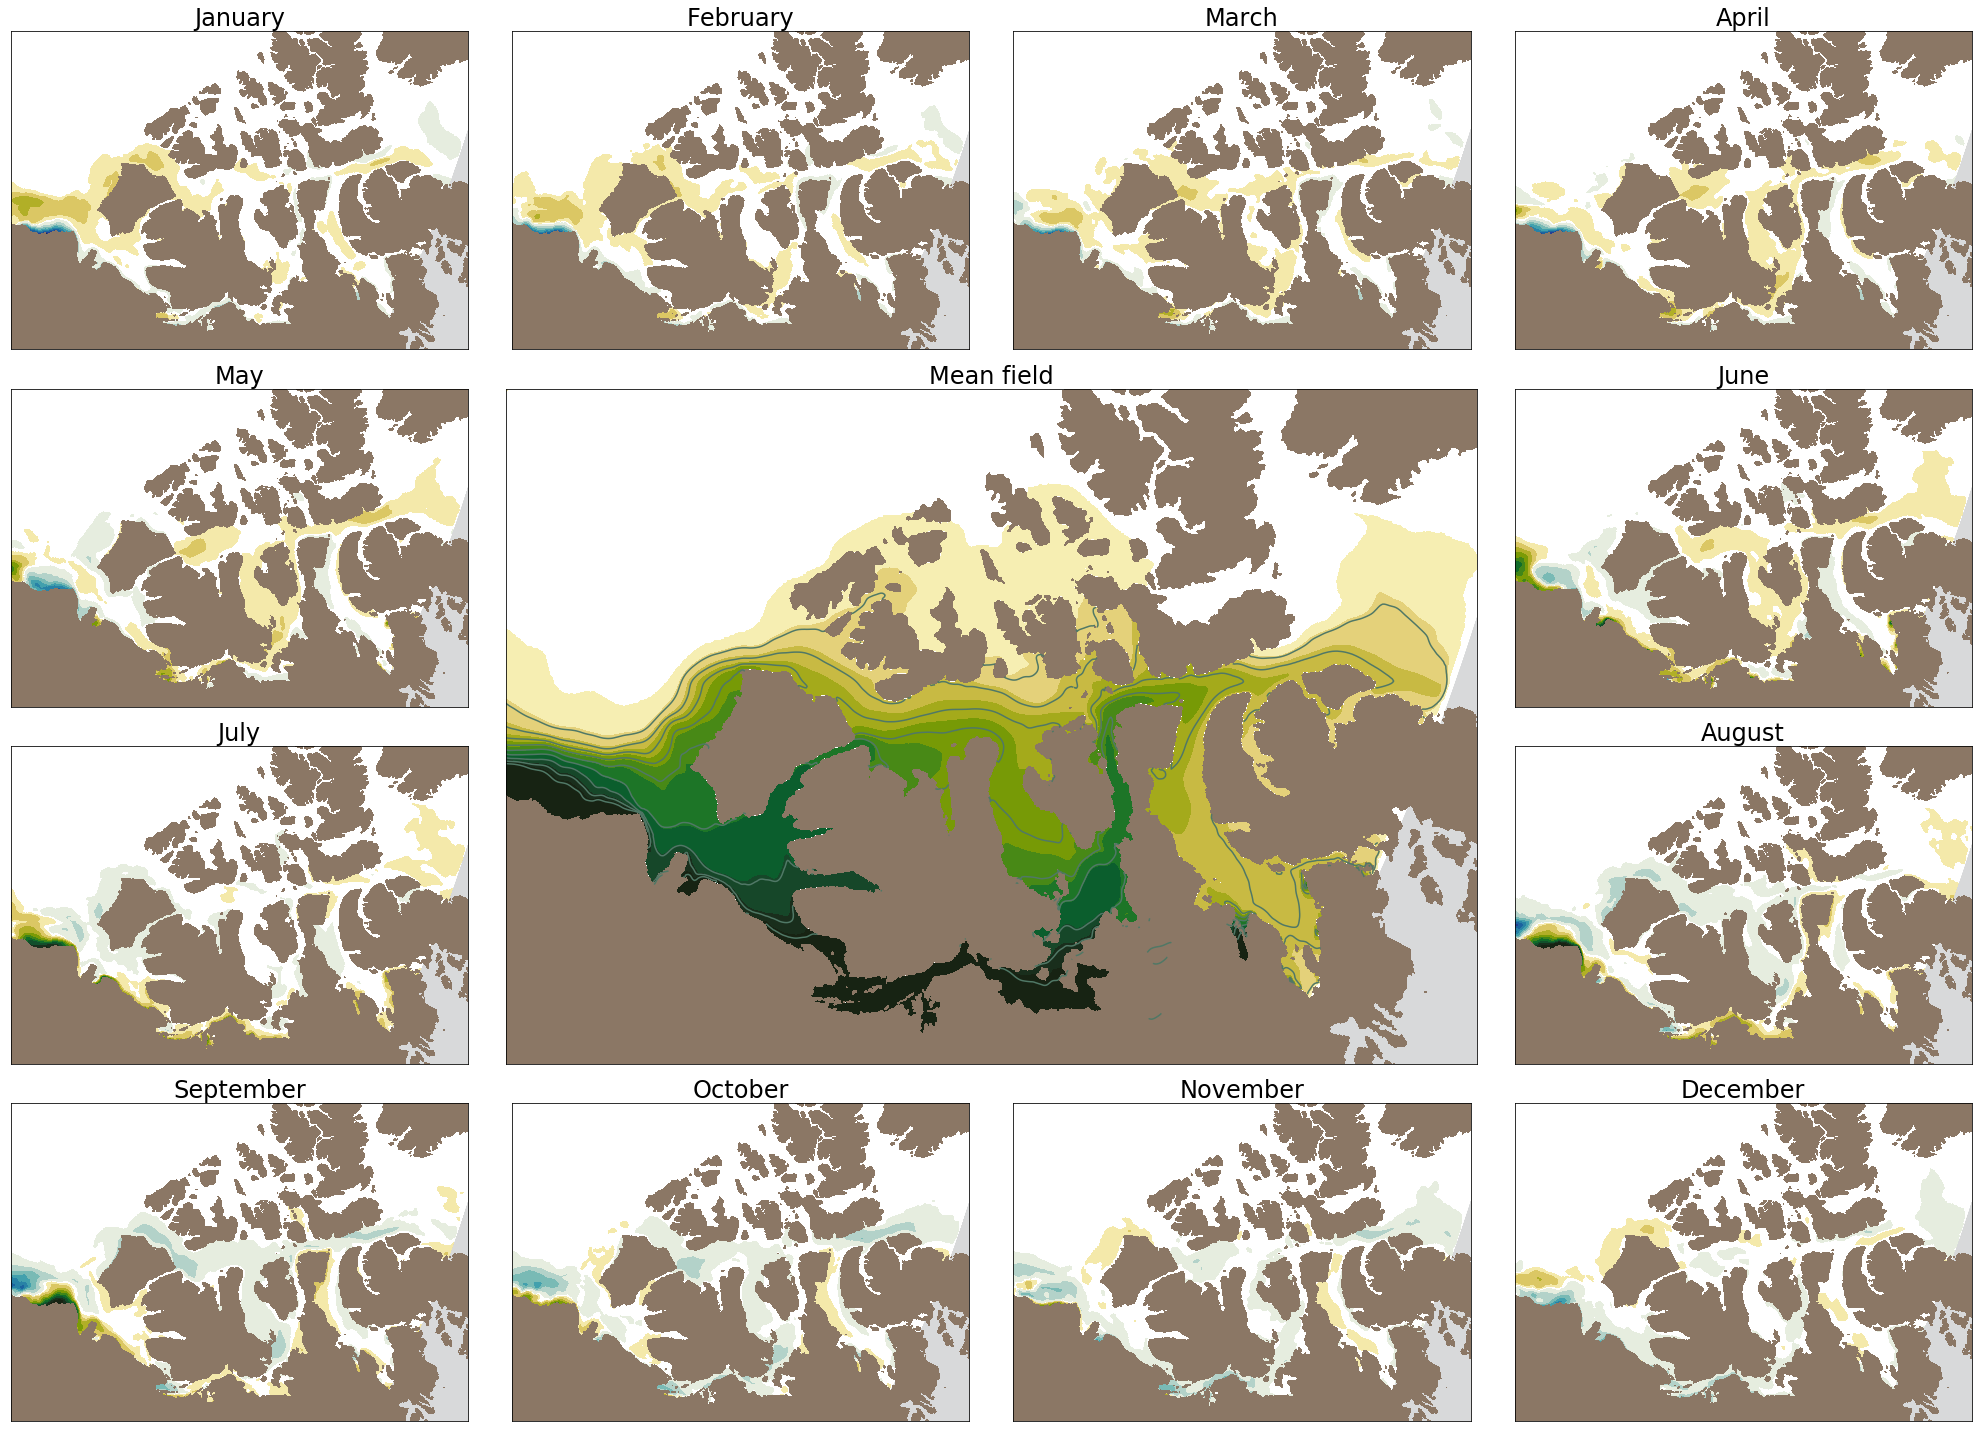

In [25]:
fig, ax = plt.subplots(4,4, figsize=(28,20))

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', \
         'August', 'September', 'October', 'November', 'December']

for month in range(0,12):
    if month < 4:
        ax1 = ax[0,month]
    elif (month == 4):
        ax1 = ax[1,0]
    elif (month == 5):
        ax1 = ax[1,3]
    elif (month == 6):
        ax1 = ax[2,0]
    elif (month == 7):
        ax1 = ax[2,3]
    else:
        ax1 = ax[3,month-8]
    
    proj2 = Basemap(projection='stere',lat_0 = 74, lon_0 = -105, resolution='l', width=2.3e6, height=1.6e6, ax=ax1)

    x_land, y_land = proj2(lon, lat)
    proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
                   cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

    #---------------------
    x_model, y_model = proj2(lons, lats)

    
    if month==13:#reference_month:
        # Coloured contours:
        vmin_cont = -8; vmax_cont = 8; step_cont = 1;
        CS1 = proj2.contourf(x_model, y_model, ma_cont[month,:,:]*100, \
                             levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                             vmin=vmin_cont, vmax=vmax_cont, cmap=cmocean.cm.delta, extend='both')
    else:
        vmin_cont = -8; vmax_cont = 8; step_cont = 1;
        CS1 = proj2.contourf(x_model, y_model, diff_continental[month], \
                             levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                             vmin=vmin_cont, vmax=vmax_cont, cmap=cmocean.cm.delta, extend='both')
        
    # Draw domain boundaries:
    proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#d8d9da', linewidth=10, zorder=1)
    proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#d8d9da', linewidth=10, zorder=1)
    
    ax1.set_title(months[month], fontsize=24)

ax2 = plt.subplot2grid((4, 4), (1, 1), colspan=2, rowspan=2)
proj2 = Basemap(projection='stere',lat_0 = 74, lon_0 = -105, resolution='l', width=2.3e6, height=1.6e6, ax=ax2)
x_land, y_land = proj2(lon, lat)
proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
               cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

x_model, y_model = proj2(lons, lats)

vmin_cont = -10; vmax_cont = 10; step_cont = 1;
refc_masked = np.ma.masked_where((refc*100 < 0.25), refc*100)

CS1 = proj2.contourf(x_model, y_model, refc_masked, \
                     levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                     vmin=vmin_cont, vmax=vmax_cont, cmap=cmocean.cm.delta, extend='both')


vmin_ccont = 0; contour_cont = 1.15; cvmax_cont = 10;
cont = proj2.contour(x_model, y_model, refc_masked, \
                     levels=np.arange(vmin_ccont, cvmax_cont+contour_cont, contour_cont), \
                     vmin=vmin_ccont, vmax=vmax_cont, colors='#507866')

proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#d8d9da', linewidth=10, zorder=1)
proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#d8d9da', linewidth=10, zorder=1)
proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#d8d9da', linewidth=10, zorder=1)
proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#d8d9da', linewidth=10, zorder=1)

ax2.set_title('Mean field', fontsize=24)
    
    
# ax2.text(0.0, 'Mean field', fontsize=24)
plt.tight_layout() # pad=0.4, w_pad=0.5, h_pad=0.1

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R7-monthly-CAA.png', bbox_inches='tight', dpi=300)

# New attempt at seasonality figure

In [59]:
reference_month = 5
# refc = cont_prop[reference_month,:,:]
# refg = glac_prop[reference_month,:,:]
refc = np.nanmean(cont_prop[:,:,:], axis=0)
refg = np.nanmean(glac_prop[:,:,:], axis=0)
ref_continental = np.ma.masked_where((refc*100 < 0.5), refc*100)
ref_glacier     = np.ma.masked_where((refg*100 < 0.5), refg*100)

diff_glac    = np.array([(glac_prop[month,:,:]-refg)*100 for month in range(0,12)])
diff_glacier = np.ma.masked_where((diff_glac < 0.3) & (diff_glac > -0.3), diff_glac)

diff_cont        = np.array([(cont_prop[month,:,:]-refc)*100 for month in range(0,12)])
diff_continental = np.ma.masked_where((diff_cont < 0.3) & (diff_cont > -0.3), diff_cont)

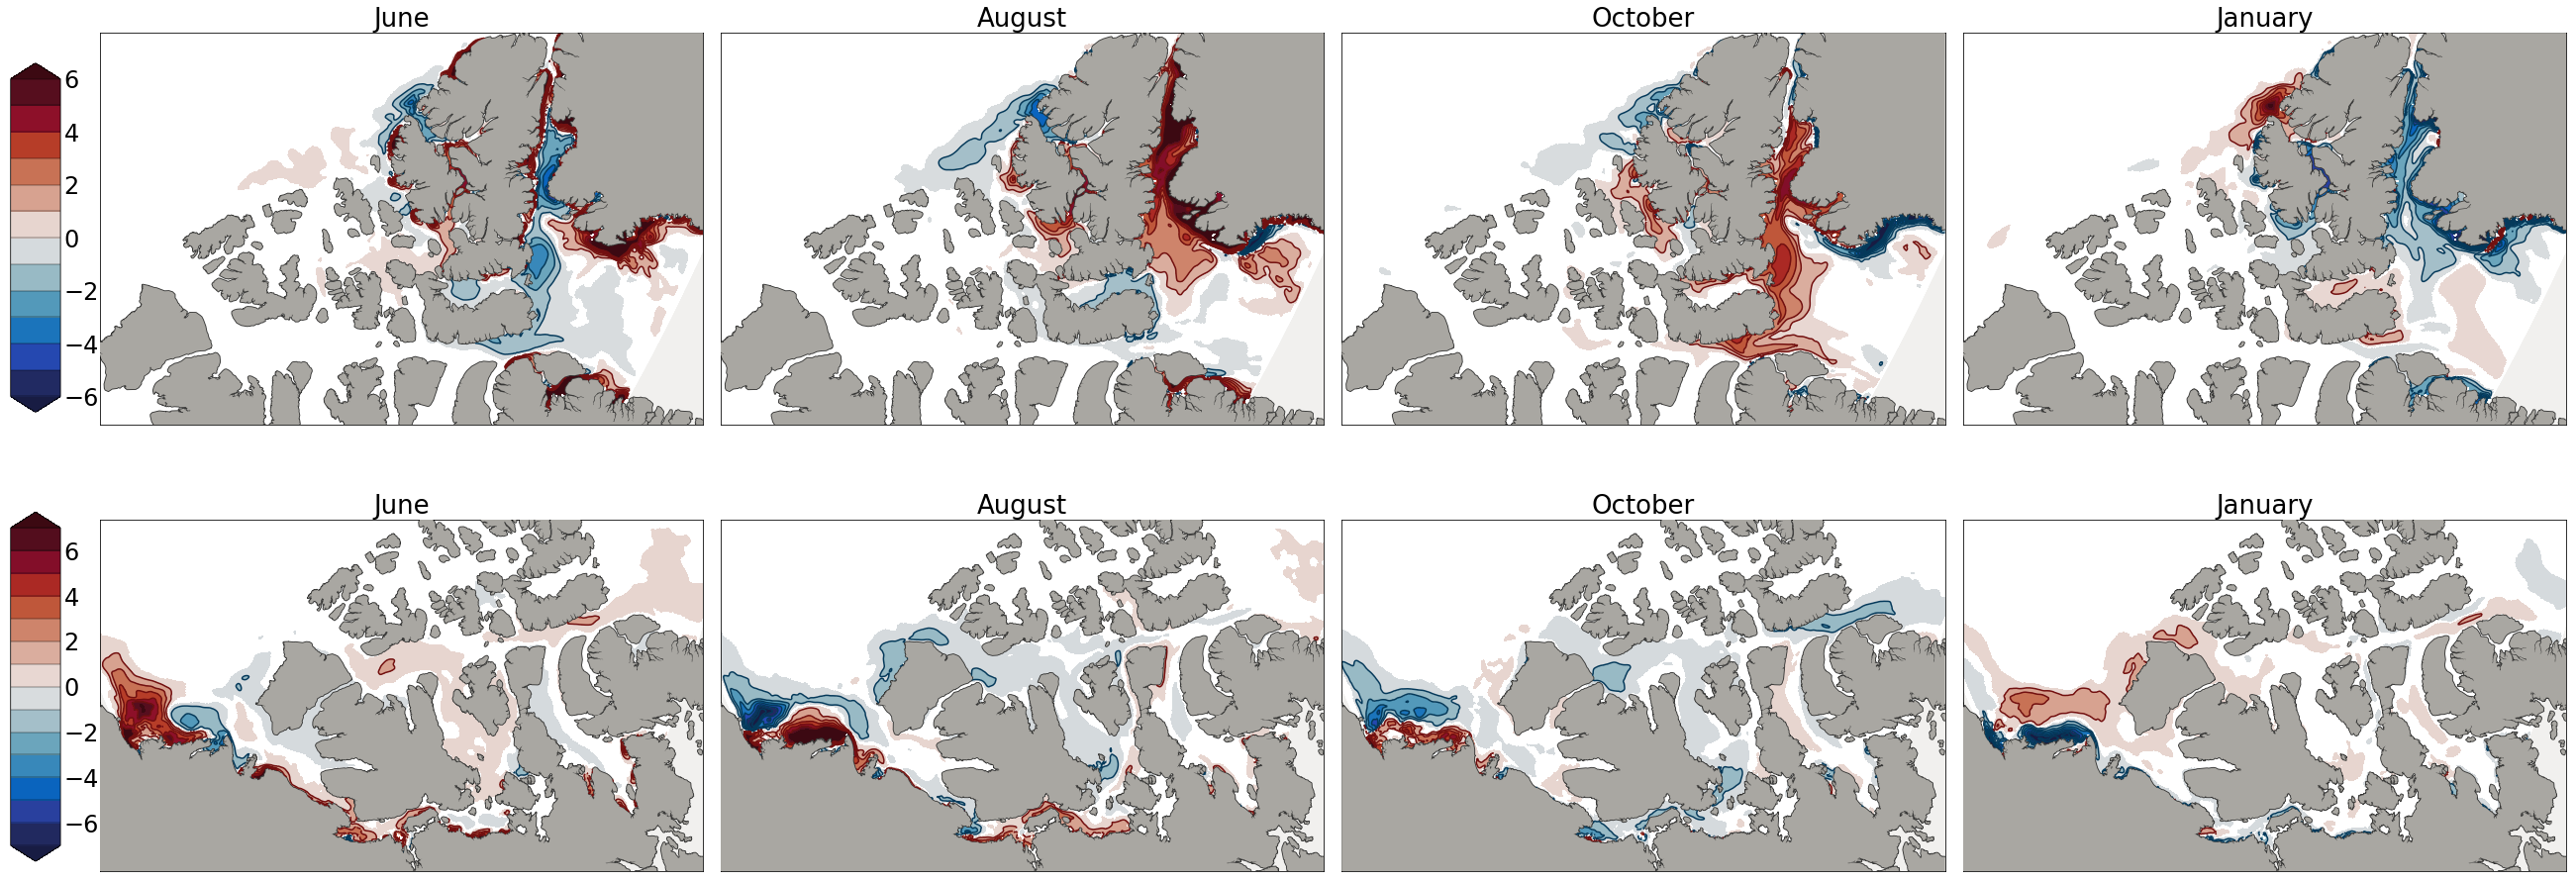

In [56]:
months     = ['June', 'August', 'October', 'January']
indices    = [5,7,9,0]
vmin_cont  = -6; vmax_cont = 6; step_cont = 1;
vmin_glac  = -7; vmax_glac = 7; step_glac = 1;
cmap_here1 = cmocean.cm.balance #matplotlib.cm.get_cmap('PuOr_r') #cmocean.cm.balance # continental
cmap_here2 = cmocean.cm.balance #matplotlib.cm.get_cmap('BrBG') # glacial

ref_min = 0; ref_max=10;

fig, ax = plt.subplots(2,4, figsize=(35,14))

for panel in range(0,4):
    for row in range(0,2):
        if row==1:
            # Map:
            proj2 = Basemap(projection='stere',lat_0 = 73, lon_0 = -109, resolution='i',\
                            width=2.4e6, height=1.4e6, ax=ax[row,panel])
            x_land, y_land   = proj2(lon, lat)
            x_model, y_model = proj2(lons, lats)
            proj2.drawcoastlines(color='#373736', linewidth=1.8)
            proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
            
            # Reference panel (January)
            if panel==4:
                proj2.contourf(x_model, y_model, ref_continental, levels=np.arange(0,ref_max,1), \
                               vmin=ref_min, vmax=ref_max, cmap=matplotlib.cm.get_cmap('Greens'), extend='both')
                
                proj2.contour(x_model, y_model, ref_continental, \
                              levels=np.arange(0, ref_max, 1), \
                              vmin=0, vmax=ref_max, colors='k')
            else:
                CS1 = proj2.contourf(x_model, y_model, diff_continental[indices[panel],:,:], \
                                     levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                                     vmin=vmin_cont, vmax=vmax_cont, cmap=cmap_here2, extend='both')
                proj2.contour(x_model, y_model, diff_continental[indices[panel],:,:], \
                              levels=np.arange(vmin_cont-1, 1, 1), \
                              vmin=vmin_cont, vmax=1, colors='#04395a', linestyles='-')
                proj2.contour(x_model, y_model, diff_continental[indices[panel],:,:], \
                              levels=np.arange(0, vmax_cont, 1), \
                              vmin=-1, vmax=vmax_cont+1, colors='#721010')
            
        else:       
            # Map:
            proj2 = Basemap(projection='stere',lat_0 = 78, lon_0 = -95, resolution='i', \
                            width=2.0e6, height=1.3e6, ax=ax[row,panel])
            x_land, y_land   = proj2(lon, lat)
            x_model, y_model = proj2(lons, lats)
            proj2.drawcoastlines(color='#373736', linewidth=1.8)
            proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
            
            # Reference panel (January)
            if panel==4:
                proj2.contourf(x_model, y_model, ref_glacier, levels=np.arange(0,ref_max,1), \
                               vmin=ref_min, vmax=ref_max, cmap=matplotlib.cm.get_cmap('Greens'), extend='both') 
                
                proj2.contour(x_model, y_model, ref_glacier, \
                              levels=np.arange(0, ref_max, 1), \
                              vmin=0, vmax=ref_max, colors='k')
            else: 
                CS2 = proj2.contourf(x_model, y_model, diff_glacier[indices[panel],:,:], \
                                     levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                                     vmin=vmin_glac, vmax=vmax_glac, cmap=cmap_here2, extend='both')
                
                proj2.contour(x_model, y_model, diff_glacier[indices[panel],:,:], \
                              levels=np.arange(vmin_glac-1, 1, 1), \
                              vmin=vmin_glac-1, vmax=1, colors='#04395a', linestyles='-')
                proj2.contour(x_model, y_model, diff_glacier[indices[panel],:,:], \
                              levels=np.arange(0, vmax_glac, 1), \
                              vmin=0, vmax=vmax_glac, colors='#721010')
    

        # Draw domain boundaries:
        proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#f1f0ee', linewidth=10, zorder=1)
        proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#f1f0ee', linewidth=10, zorder=1)
        proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#f1f0ee', linewidth=10, zorder=1)
        proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#f1f0ee', linewidth=10, zorder=1)

        ax[row,panel].set_title(months[panel], fontsize=26)
        
cbaxes1 = fig.add_axes([-0.03, 0.10, 0.02, 0.35]) 
cbaxes2 = fig.add_axes([-0.03, 0.55, 0.02, 0.35])  
CBar1   = plt.colorbar(CS1, ax=ax[0,0], cax=cbaxes2, ticks=np.arange(-8,8,2), drawedges=True) 
CBar2   = plt.colorbar(CS2, ax=ax[1,0], cax=cbaxes1, ticks=np.arange(-8,8,2), drawedges=True) 
CBar1.ax.tick_params(axis='y', length=0, labelsize=24)
CBar2.ax.tick_params(axis='y', length=0, labelsize=24)
        
plt.tight_layout()

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R3-difference-mean.png', bbox_inches='tight', dpi=300)

Mean field:

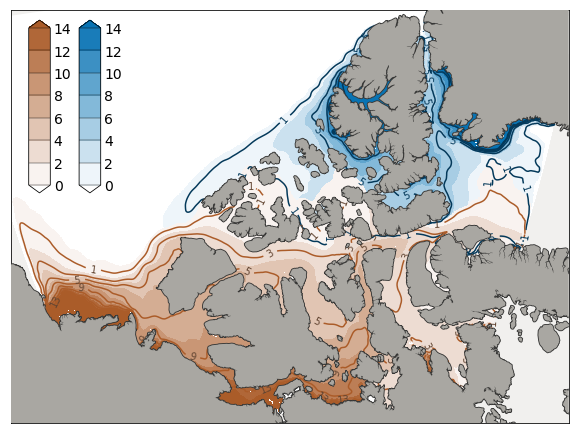

In [75]:
fig, ax1 = plt.subplots(figsize=(10,12))

proj2 = Basemap(projection='stere',lat_0 = 76, lon_0 = -107, resolution='i', width=2.7e6, height=2.0e6, ax=ax1)
x_land, y_land = proj2(lon, lat)
proj2.drawcoastlines(color='#373736', linewidth=1.8, zorder=4)
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=4);

#---------------------
x_model, y_model = proj2(lons, lats)

# Coloured contours:
vmin_cont = 0; vmax_cont = 14; step_cont = 2;
vmin_glac = 0; vmax_glac = 14; step_glac = 2;
CS1 = proj2.contourf(x_model, y_model, ref_glacier, \
                     levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                     vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap, extend='both')
CS2 = proj2.contourf(x_model, y_model, ref_continental, \
                     levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                     vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap, extend='both')

# Contour lines:
vmin_cglac=1; vmin_ccont = 1;
contour_glac = 4; cvmax_glac = 14;
contour_cont = 2; cvmax_cont = 14;
glac = proj2.contour(x_model, y_model, ref_glacier, \
                     levels=np.arange(vmin_cglac, cvmax_glac+contour_glac, contour_glac), \
                     vmin=vmin_cglac, vmax=vmax_glac, colors='#04395a');
cont = proj2.contour(x_model, y_model, ref_continental, \
                     levels=np.arange(vmin_ccont, cvmax_cont+contour_cont, contour_cont), \
                     vmin=vmin_ccont, vmax=vmax_cont, colors='#ab5c29');


# Draw domain boundaries:
proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#f1f0ee', linewidth=10, zorder=1);
proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#f1f0ee', linewidth=10, zorder=1);
proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#f1f0ee', linewidth=10, zorder=1);
proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#f1f0ee', linewidth=10, zorder=1);

ax1.clabel(glac, [1, 5], inline=1, fontsize=10, fmt='%1.f')
ax1.clabel(cont, [1, 3, 5, 9, 13], inline=1, fontsize=10, colors='#624532', fmt='%1.f')

# Colorbars:
cbaxes1 = fig.add_axes([0.15, 0.53, 0.03, 0.20]) 
cbaxes2 = fig.add_axes([0.22, 0.53, 0.03, 0.20])  
CBar1   = plt.colorbar(CS1, ax=ax1, cax=cbaxes2, ticks=np.arange(0,16,2), drawedges=True) 
CBar2   = plt.colorbar(CS2, ax=ax1, cax=cbaxes1, ticks=np.arange(0,16,2), drawedges=True) 
CBar1.ax.tick_params(axis='y', length=0, labelsize=14)
CBar2.ax.tick_params(axis='y', length=0, labelsize=14)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R3-mean-field.png', bbox_inches='tight', dpi=300)

Glacial runoff:

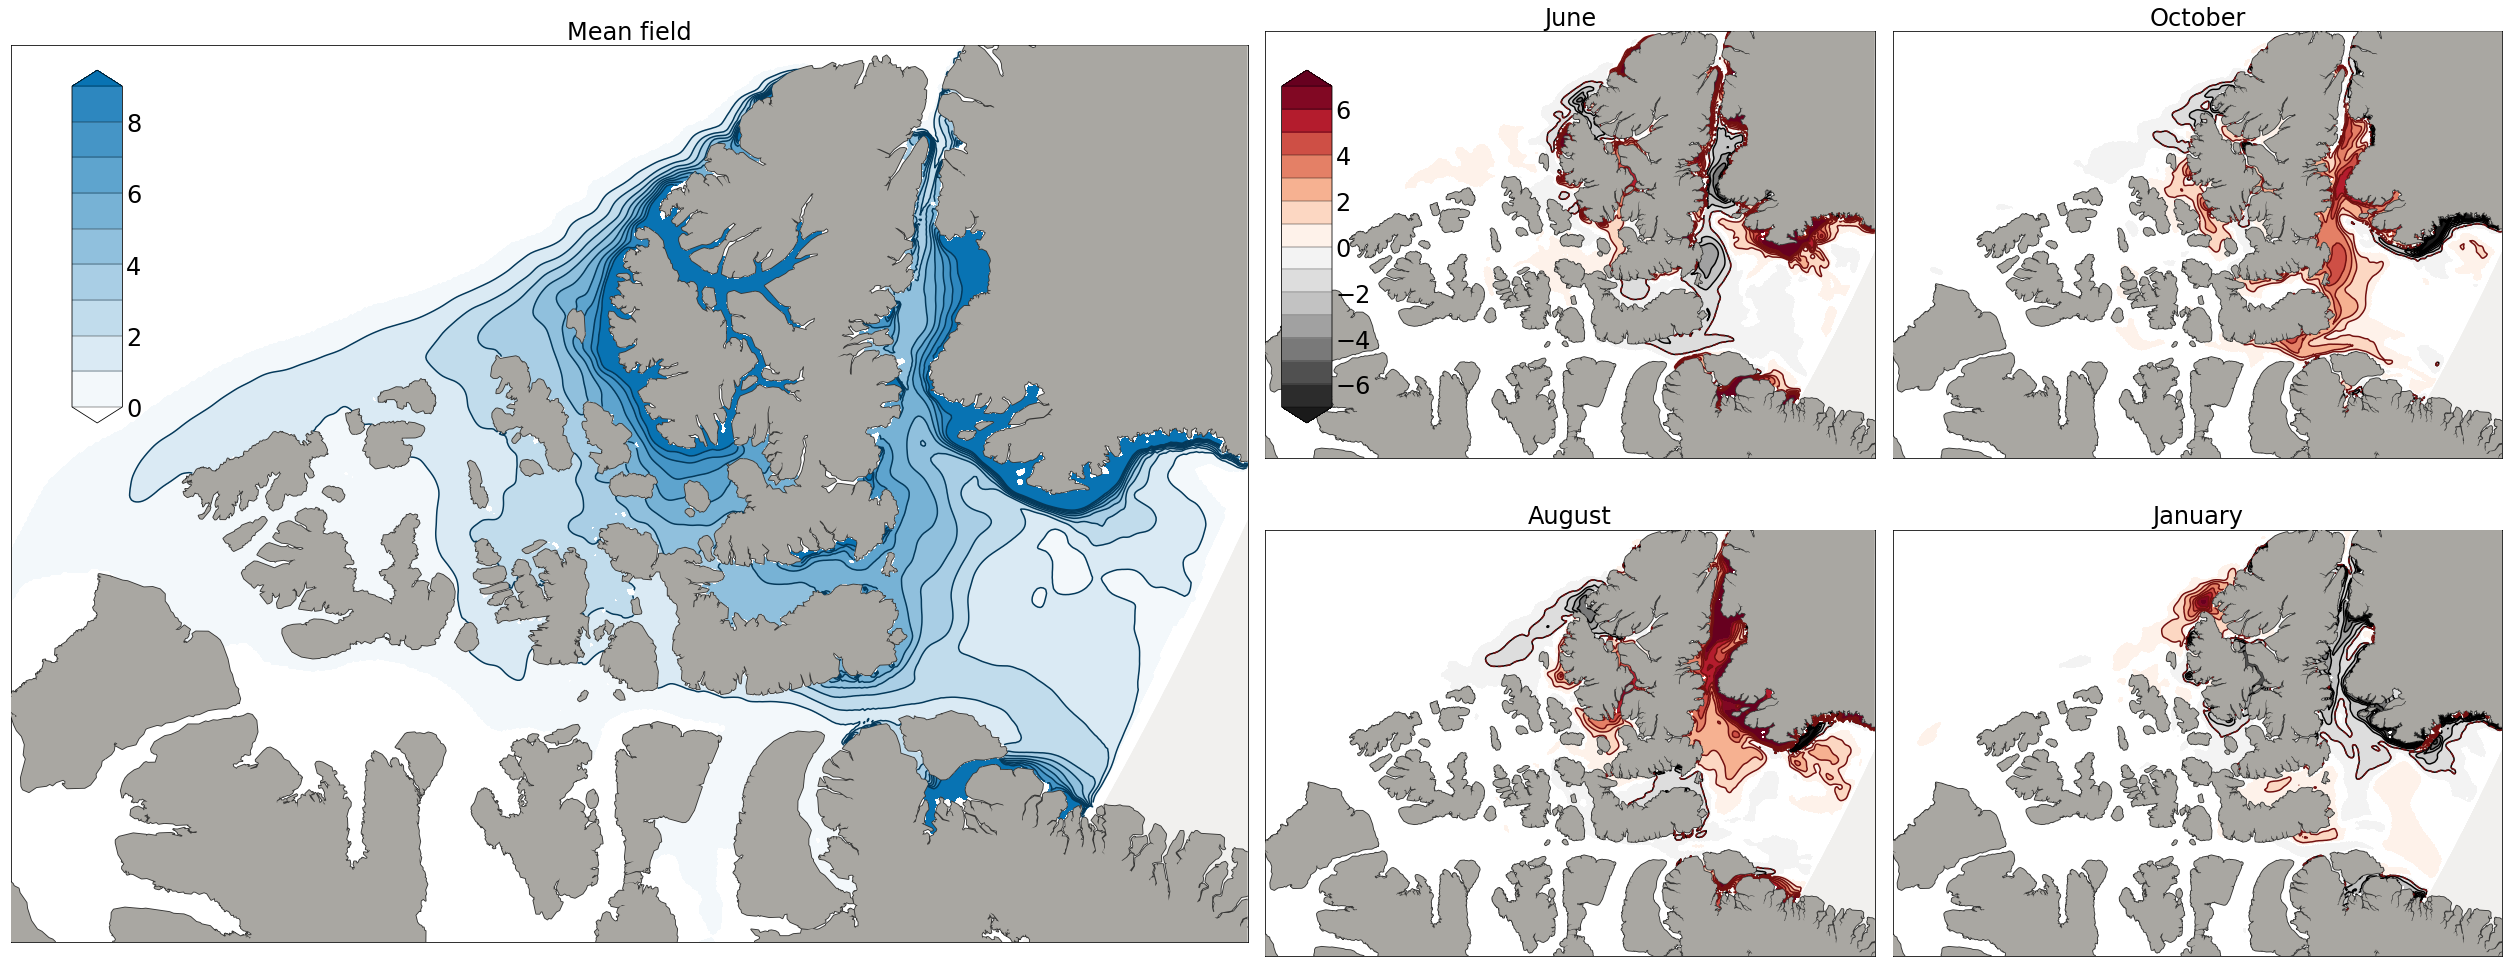

In [50]:
fig, ax = plt.subplots(2,4, figsize=(35,14))

months     = ['June', 'August', 'October', 'January']
indices    = [5,7,9,0]
vmin_glac  = -7; vmax_glac = 7; step_glac = 1;
ref_min    = 0;  ref_max   = 10;

#----------------- Difference from mean field -----------------------------------------------------
i=0
for panel in range(2,4):
    for row in range(0,2):
        # Map:
        proj2 = Basemap(projection='stere',lat_0 = 77.5, lon_0 = -95, resolution='i', \
                        width=2.0e6, height=1.4e6, ax=ax[row,panel])
        x_land, y_land   = proj2(lon, lat)
        x_model, y_model = proj2(lons, lats)
        proj2.drawcoastlines(color='#373736', linewidth=1.8)
        proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
            
        # Coloured contours and contour lines:
        CS2 = proj2.contourf(x_model, y_model, diff_glacier[indices[i],:,:], \
                             levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                             vmin=vmin_glac, vmax=vmax_glac, cmap=matplotlib.cm.get_cmap('RdGy_r'), extend='both')   
        proj2.contour(x_model, y_model, diff_glacier[indices[i],:,:], \
                      levels=np.arange(vmin_glac-1, 1, 1), \
                      vmin=vmin_glac-1, vmax=1, colors='k', linestyles='-')
        proj2.contour(x_model, y_model, diff_glacier[indices[i],:,:], \
                      levels=np.arange(-1, vmax_glac, 1), \
                      vmin=0, vmax=vmax_glac, colors='#721010')#colors='#1c2e62')
        
        # Draw domain boundaries:
        proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#f1f0ee', linewidth=10, zorder=1)
        proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#f1f0ee', linewidth=10, zorder=1)
        proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#f1f0ee', linewidth=10, zorder=1)
        proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#f1f0ee', linewidth=10, zorder=1)

        ax[row,panel].set_title(months[i], fontsize=24)
        
        i+=1

#----------------- Mean field panel ------------------------------------------------------------
ax2   = plt.subplot2grid((2, 4), (0, 0), colspan=2, rowspan=2)
proj2 = Basemap(projection='stere',lat_0 = 77.5, lon_0 = -95, resolution='i', width=2.0e6, height=1.45e6, ax=ax2)
x_land, y_land   = proj2(lon, lat)
x_model, y_model = proj2(lons, lats)
proj2.drawcoastlines(color='#373736', linewidth=1.8)
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

CS1 = proj2.contourf(x_model, y_model, ref_glacier, levels=np.arange(0,ref_max,1), \
               vmin=ref_min, vmax=ref_max, cmap=glac_cmap, extend='both')  # matplotlib.cm.get_cmap('bone_r')
proj2.contour(x_model, y_model, ref_glacier, levels=np.arange(0,ref_max, 1), \
              vmin=0, vmax=ref_max, colors='#04395a')

# Draw domain boundaries:
proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#f1f0ee', linewidth=10, zorder=1)
proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#f1f0ee', linewidth=10, zorder=1)
proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#f1f0ee', linewidth=10, zorder=1)
proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#f1f0ee', linewidth=10, zorder=1)

ax2.set_title('Mean field', fontsize=24)


#----------------- General settings ----------------------------------------------------------------
# colorbar:
cbaxes1 = fig.add_axes([0.03, 0.57, 0.02, 0.35]) 
CBar1   = plt.colorbar(CS1, ax=ax2, cax=cbaxes1, ticks=np.arange(0,ref_max+2,2), drawedges=True) 
CBar1.ax.tick_params(axis='y', length=0, labelsize=24)

cbaxes2 = fig.add_axes([0.51, 0.57, 0.02, 0.35]) 
CBar2   = plt.colorbar(CS2, cax=cbaxes2, ticks=np.arange(-8,8,2), drawedges=True) 
CBar2.ax.tick_params(axis='y', length=0, labelsize=24)

plt.tight_layout()

Continental runoff:

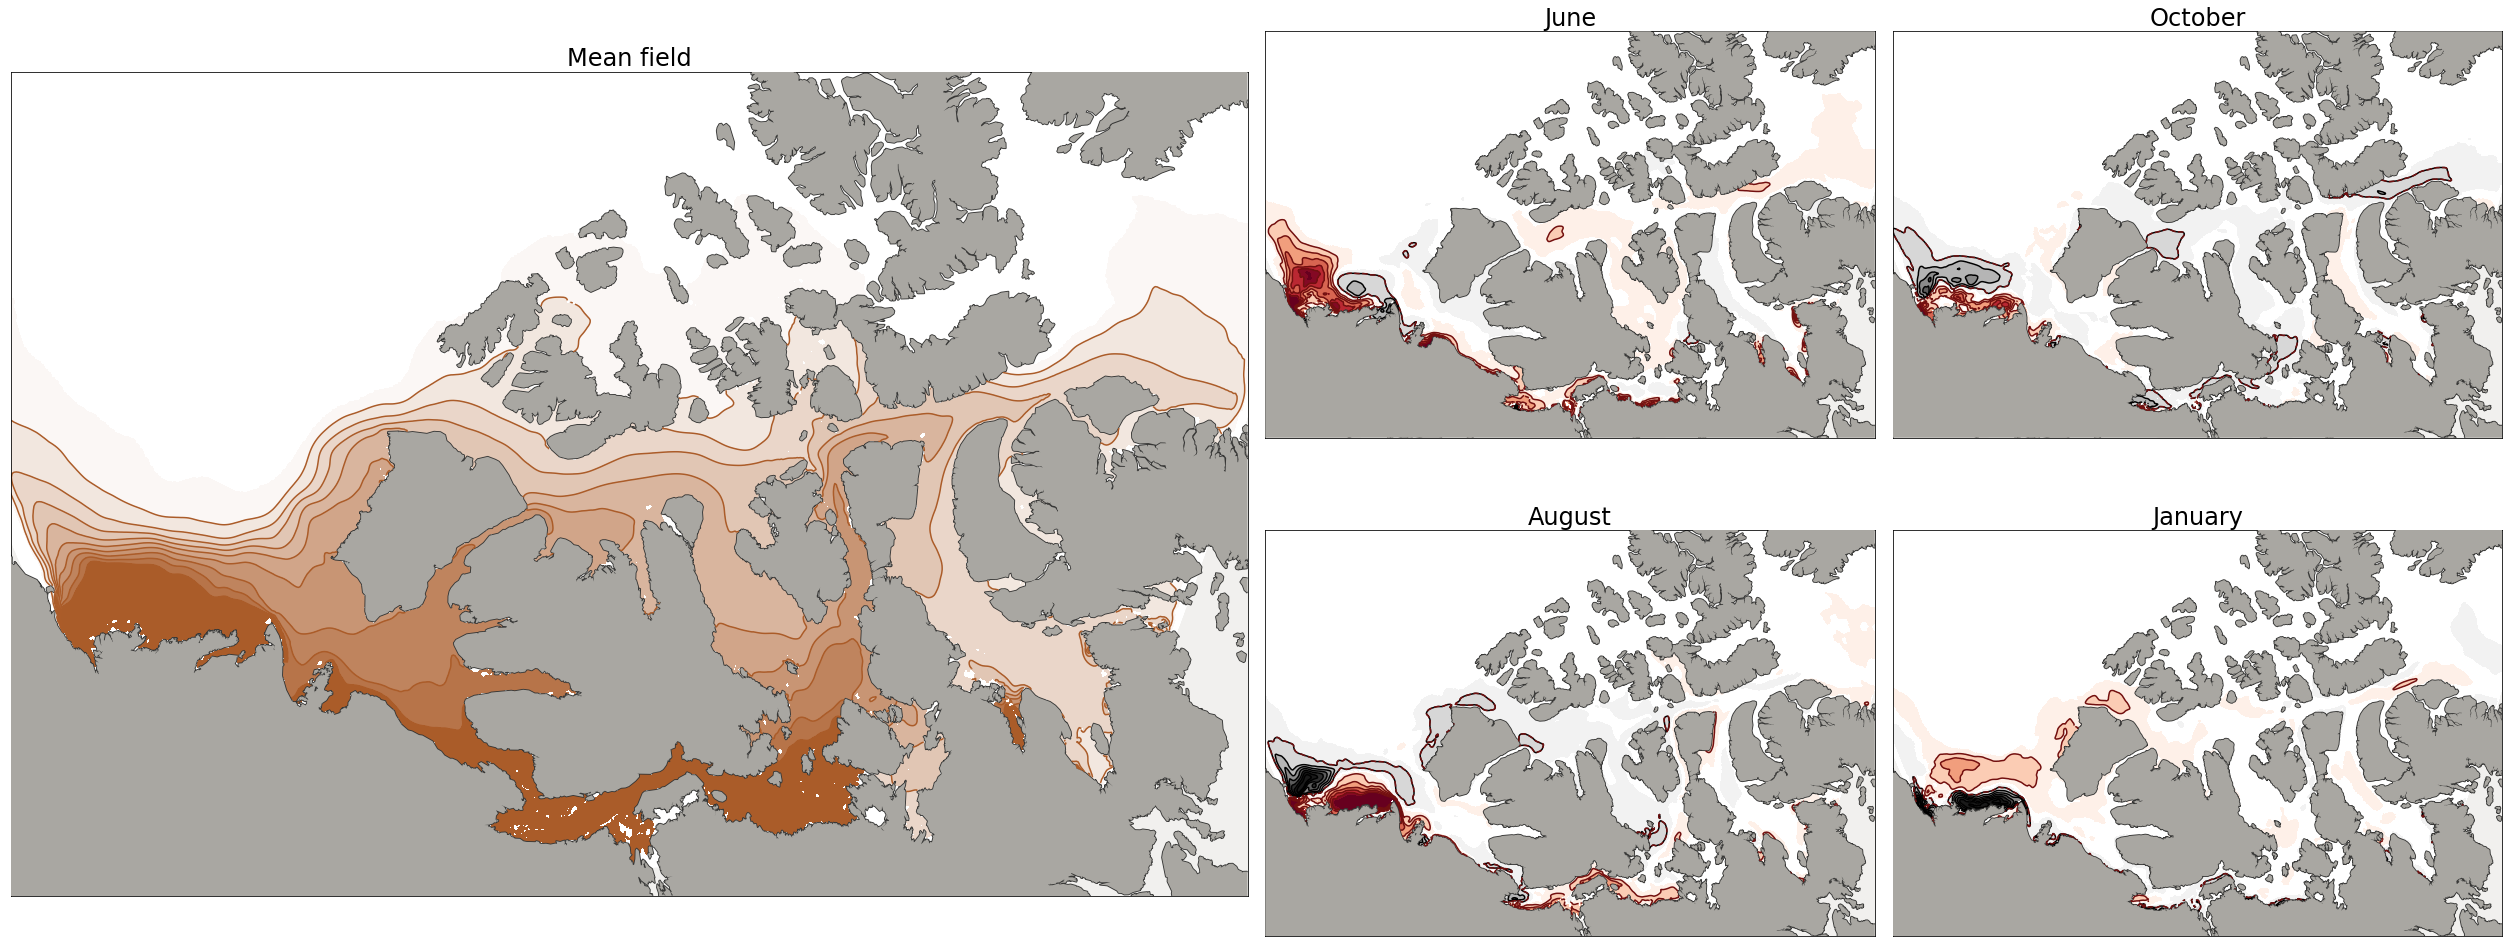

In [49]:
fig, ax = plt.subplots(2,4, figsize=(35,14))

months     = ['June', 'August', 'October', 'January']
indices    = [5,7,9,0]
vmin_cont  = -6; vmax_cont = 6; step_cont = 1;
ref_min    = 0;  ref_max   = 10;

#----------------- Difference from mean field -----------------------------------------------------
i=0
for panel in range(2,4):
    for row in range(0,2):
        # Map:
        proj2 = Basemap(projection='stere',lat_0 = 74, lon_0 = -109, resolution='i',\
                            width=2.4e6, height=1.6e6, ax=ax[row,panel])
        x_land, y_land   = proj2(lon, lat)
        x_model, y_model = proj2(lons, lats)
        proj2.drawcoastlines(color='#373736', linewidth=1.8)
        proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
            
        # Coloured contours and contour lines:
        CS2 = proj2.contourf(x_model, y_model, diff_continental[indices[i],:,:], \
                             levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                             vmin=vmin_cont, vmax=vmax_cont, cmap=matplotlib.cm.get_cmap('RdGy_r'), extend='both')   
        proj2.contour(x_model, y_model, diff_continental[indices[i],:,:], \
                      levels=np.arange(vmin_cont-1, 1, 1), \
                      vmin=vmin_cont-1, vmax=1, colors='k', linestyles='-')
#                       vmin=vmin_cont-1, vmax=1, colors='#1c2e62', linestyles='-')
        proj2.contour(x_model, y_model, diff_continental[indices[i],:,:], \
                      levels=np.arange(-1, vmax_cont, 1), \
                      vmin=0, vmax=vmax_cont, colors='#721010')
        
        # Draw domain boundaries:
        proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#f1f0ee', linewidth=10, zorder=1)
        proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#f1f0ee', linewidth=10, zorder=1)
        proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#f1f0ee', linewidth=10, zorder=1)
        proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#f1f0ee', linewidth=10, zorder=1)

        ax[row,panel].set_title(months[i], fontsize=24)
        
        i+=1

#----------------- Mean field panel ------------------------------------------------------------
ax2   = plt.subplot2grid((2, 4), (0, 0), colspan=2, rowspan=2)
proj2 = Basemap(projection='stere',lat_0 = 74, lon_0 = -109, resolution='i', width=2.4e6, height=1.6e6, ax=ax2)
x_land, y_land   = proj2(lon, lat)
x_model, y_model = proj2(lons, lats)
proj2.drawcoastlines(color='#373736', linewidth=1.8)
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

proj2.contourf(x_model, y_model, ref_continental, levels=np.arange(0,ref_max,1), \
               vmin=ref_min, vmax=ref_max, cmap=cont_cmap, extend='both') 
proj2.contour(x_model, y_model, ref_continental, levels=np.arange(0,ref_max, 1), \
              vmin=0, vmax=ref_max, colors='#ab5c29')

# Draw domain boundaries:
proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#f1f0ee', linewidth=10, zorder=1)
proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#f1f0ee', linewidth=10, zorder=1)
proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#f1f0ee', linewidth=10, zorder=1)
proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#f1f0ee', linewidth=10, zorder=1)

ax2.set_title('Mean field', fontsize=24)
plt.tight_layout()